In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import joblib

In [2]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

In [3]:
df.sample(5)

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
789,GBM,TCGA-GBM,TCGA-02-2466,Male,61 years 177 days,Glioblastoma,white,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
776,GBM,TCGA-GBM,TCGA-12-0829,Male,75 years 78 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
126,LGG,TCGA-LGG,TCGA-HT-7474,Male,52 years 156 days,Mixed glioma,white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
95,LGG,TCGA-LGG,TCGA-S9-A6WL,Male,52 years 241 days,"Astrocytoma, anaplastic",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
369,LGG,TCGA-LGG,TCGA-RY-A83X,Female,46 years 110 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

## EDA

### Целевая переменнная Grade

In [5]:
df.Grade.value_counts()

LGG    499
GBM    363
Name: Grade, dtype: int64

Дисбаланса классов нет.

### Project

In [6]:
df.Project.value_counts()

TCGA-LGG    499
TCGA-GBM    363
Name: Project, dtype: int64

Предполагаю, что именно здесь утечка данных, т.к. параметр полностью повторяет целевую переменную. Для чистоты метрик его надо удалить.

### Case_ID

In [7]:
df.Case_ID.value_counts()

TCGA-DU-8164    1
TCGA-19-1786    1
TCGA-28-5219    1
TCGA-14-1455    1
TCGA-41-2575    1
               ..
TCGA-FG-6689    1
TCGA-HT-8013    1
TCGA-HT-A616    1
TCGA-DU-7008    1
TCGA-06-2557    1
Name: Case_ID, Length: 862, dtype: int64

Вероятно, это номер истории болезни пациента в рамках проекта и информации он не несет. Столбец также для удаления.

Однако, любопытно посмотреть на распределение второй группы в этом номере.

In [8]:
df.Case_ID.apply(lambda x: x.split('-')[1]).value_counts()

06    111
HT     98
DU     81
S9     47
12     41
FG     40
19     34
DB     34
14     33
E1     29
28     27
76     24
P5     24
QH     21
32     21
TM     19
CS     19
TQ     17
27     16
DH     15
HW     14
26     11
41     10
02      9
16      8
VM      8
WY      7
RY      7
74      6
R8      5
4W      3
RR      3
15      2
IK      2
81      2
F6      2
VV      2
KT      2
VW      2
W9      1
EZ      1
WH      1
FN      1
OX      1
87      1
Name: Case_ID, dtype: int64

In [9]:
len(df.Case_ID.apply(lambda x: x.split('-')[1]).value_counts())

45

Возможно, тут может что-то быть зашифровано, но перевод в label задаст отношение порядка между переменными. А OHE даст очень сильную разреженность, что нежелательно для этих данных, т.к. наблюдений и так очень небольшое количество.

Этот признак также удаляем.

### Gender

In [10]:
df.Gender.value_counts()

Male      499
Female    359
--          4
Name: Gender, dtype: int64

Ничего не будем делать с отсутвующими данными. Оставим иx нулем.

### Age_at_diagnosis

In [11]:
df.Age_at_diagnosis.value_counts()

--                   5
64 years 298 days    3
38 years 203 days    2
52 years 156 days    2
30 years 32 days     2
                    ..
36 years 73 days     1
41 years 314 days    1
57 years 201 days    1
52 years 243 days    1
76 years 221 days    1
Name: Age_at_diagnosis, Length: 838, dtype: int64

Заменим возраст днями и посмотрим распределение.

In [12]:
def get_days(age):
    if age == '--':
        return 0
    else:
        if len(age.split()) == 2:
            years = int(age.split()[0])
            return years * 365 + years//4
        else:
            years = int(age.split()[0])
            days = int(age.split()[2])
            return years * 365 + days + years//4

In [13]:
df['Days_at_diagnosis'] = df.Age_at_diagnosis.progress_apply(get_days)

  0%|          | 0/862 [00:00<?, ?it/s]

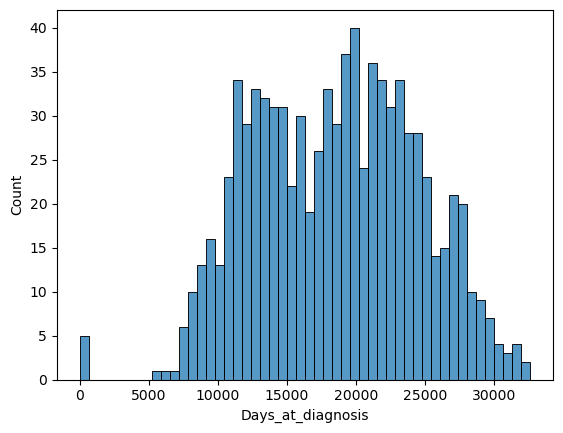

In [14]:
sb.histplot(df['Days_at_diagnosis'], bins=50);

In [15]:
df['Days_at_diagnosis'].median()

18769.5

Нули можно заменить медианой. Столбец Age_at_diagnosis удаляем, оставляем дни.

### Primary_Diagnosis

In [16]:
df.Primary_Diagnosis.value_counts()

Glioblastoma                     360
Astrocytoma, anaplastic          129
Mixed glioma                     128
Oligodendroglioma, NOS           108
Oligodendroglioma, anaplastic     75
Astrocytoma, NOS                  58
--                                 4
Name: Primary_Diagnosis, dtype: int64

In [17]:
df[df.Primary_Diagnosis == '--']

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Days_at_diagnosis
41,LGG,TCGA-LGG,TCGA-R8-A6YH,--,--,--,--,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,0
671,GBM,TCGA-GBM,TCGA-28-2501,--,--,--,--,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,0
706,GBM,TCGA-GBM,TCGA-28-2510,--,--,--,--,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,0
794,GBM,TCGA-GBM,TCGA-16-1048,--,--,--,--,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,0


4 строки содржат отсутвующие значения в столбцах с возрастом, полом, предварительным диагнозом и рассой. Это могут быть ошибочные данные, поэтому их можно удалить.

Второй подход - заменить все данные средними значениями, т.о. получить усредненный результат. Но тут смущает то, что признаки IDH1, TP53, ATRX отличаются в эти строках и таким образом можно внести шум.

In [18]:
ind = df[df.Primary_Diagnosis == '--'].index

In [19]:
df.drop(index=ind, inplace=True)

### Race

In [20]:
df.Race.value_counts()

white                               766
black or african american            59
not reported                         18
asian                                14
american indian or alaska native      1
Name: Race, dtype: int64

Вероятно эти параметры можно укрупнить до 3 групп, но, предположительно, расса может играть роль в распространении опухоли, можно кодировать данные OHE. С другой стороны, в датасете не так много данных, чтобы добавлять разреженность,и метки могут быть более подходящими для этих данных.

In [21]:
df['Days_at_diagnosis'].median()

18813.5

##### Осталась одна строка с отсутствующим значением возраста.

In [22]:
df[df.Days_at_diagnosis == 0]

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Days_at_diagnosis
437,LGG,TCGA-LGG,TCGA-W9-A837,Male,--,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,0


Заменим на медиану возраста в группе белых мужчин с аналогичным диагнозом

In [23]:
med = df[(df.Gender == 'Male') & (df.Primary_Diagnosis == 'Oligodendroglioma, NOS') & (df.Race=='white')]['Days_at_diagnosis'].median()

In [24]:
df.loc[df['Days_at_diagnosis']==0, 'Days_at_diagnosis'] = med

### IDH1, TP53, ATRX, PTEN, EGFR, CIC, MUC16, PIK3CA, NF1, PIK3R1, FUBP1, RB1, NOTCH1, BCOR, CSMD3, SMARCA4, GRIN2A, IDH2, FAT4, mPDGFRA  

In [25]:
feats = ['IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1',
         'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA',]

In [26]:
for f in feats:
    print(df[f'{f}'].value_counts())

NOT_MUTATED    445
MUTATED        413
Name: IDH1, dtype: int64
NOT_MUTATED    505
MUTATED        353
Name: TP53, dtype: int64
NOT_MUTATED    639
MUTATED        219
Name: ATRX, dtype: int64
NOT_MUTATED    715
MUTATED        143
Name: PTEN, dtype: int64
NOT_MUTATED    745
MUTATED        113
Name: EGFR, dtype: int64
NOT_MUTATED    744
MUTATED        114
Name: CIC, dtype: int64
NOT_MUTATED    759
MUTATED         99
Name: MUC16, dtype: int64
NOT_MUTATED    782
MUTATED         76
Name: PIK3CA, dtype: int64
NOT_MUTATED    789
MUTATED         69
Name: NF1, dtype: int64
NOT_MUTATED    801
MUTATED         57
Name: PIK3R1, dtype: int64
NOT_MUTATED    811
MUTATED         47
Name: FUBP1, dtype: int64
NOT_MUTATED    817
MUTATED         41
Name: RB1, dtype: int64
NOT_MUTATED    820
MUTATED         38
Name: NOTCH1, dtype: int64
NOT_MUTATED    829
MUTATED         29
Name: BCOR, dtype: int64
NOT_MUTATED    830
MUTATED         28
Name: CSMD3, dtype: int64
NOT_MUTATED    830
MUTATED         28
Name: SMARC

Все параметры представлены бинарным признаком и могут быть закодированы 0 и 1

## Подготовка данных

In [27]:
map_gen = {'Male': 0, 'Female': 1}
map_diag = {'Glioblastoma': 5,
            'Astrocytoma, anaplastic': 4,
            'Mixed glioma': 3,
            'Oligodendroglioma, NOS': 2,
            'Oligodendroglioma, anaplastic': 1,
            'Astrocytoma, NOS': 0}
map_race = {'white': 0,
            'black or african american': 1,
            'not reported': 2,
            'asian': 3,
            'american indian or alaska native': 4}
map_feat = {'MUTATED': 0,
           'NOT_MUTATED': 1}
map_grade = {'LGG': 0,
             'GBM': 1}

In [28]:
df.Grade = df.Grade.map(map_grade)
df.Gender = df.Gender.map(map_gen)
df.Primary_Diagnosis = df.Primary_Diagnosis.map(map_diag)
df.Race = df.Race.map(map_race)
for f in feats:
    df[f'{f}'] = df[f'{f}'].map(map_feat)

In [29]:
features_to_drop = ['Project', 'Case_ID', 'Age_at_diagnosis']
df.drop(columns=features_to_drop, inplace=True)

In [30]:
df.head()

,Grade,Gender,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Days_at_diagnosis
0,0,0,2,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,18735.0
1,0,0,3,0,0,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,14140.0
2,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,12845.0
3,0,1,4,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,0,1,11971.0
4,0,0,4,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,11509.0


Столбец с предварительным диагнозом сильно влияет на результат, все модели дают метрику точность = 1.0

In [31]:
X = df.drop(['Grade', 'Primary_Diagnosis'], axis=1)
y = df['Grade']
feature_names = df.drop('Grade', axis=1).columns.to_list()

In [32]:
X.shape, y.shape

((858, 23), (858,))

In [33]:
diag_mean = df.Days_at_diagnosis.mean()
diag_std = df.Days_at_diagnosis.std()

In [34]:
X_scaled = X.copy()
X_scaled['Days_at_diagnosis'] = (X_scaled.Days_at_diagnosis - diag_mean) / diag_std

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((686, 23), (172, 23), (686,), (172,))

#### Логистическая регрессия

In [37]:
lr = LogisticRegression()

In [38]:
lr.fit(X_train, y_train)

LogisticRegression()

In [39]:
y_pred = lr.predict(X_test)

In [40]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0], dtype=int64)

In [41]:
accuracy_score(y_pred, y_test)

0.8662790697674418

In [42]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87        87
           1       0.91      0.81      0.86        85

    accuracy                           0.87       172
   macro avg       0.87      0.87      0.87       172
weighted avg       0.87      0.87      0.87       172



In [43]:
lr.coef_

array([[-0.18038553,  0.08762495,  3.12800181, -0.66990209,  0.0622025 ,
        -0.85572092,  0.31944201,  0.96185332, -0.38757373,  0.1331659 ,
         0.78918879, -0.7342998 ,  0.29816371, -0.64552021,  1.46324349,
        -0.17928524, -0.31929633,  0.57084469, -1.21558794,  1.40065799,
         0.45600931, -0.55411199,  0.75432616]])

In [44]:
lr.intercept_

array([-3.42734294])

In [45]:
joblib.dump(lr, "model_lr.pkl")

['model_lr.pkl']

#### Случайный лес

In [46]:
rf = RandomForestClassifier()

In [47]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
accuracy_score(rf.predict(X_test), y_test)

0.8081395348837209

In [49]:
print(classification_report(rf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83        95
           1       0.79      0.78      0.78        77

    accuracy                           0.81       172
   macro avg       0.81      0.81      0.81       172
weighted avg       0.81      0.81      0.81       172



In [50]:
rf.feature_importances_

array([0.01987314, 0.03111937, 0.30644929, 0.02363591, 0.04353385,
       0.05351485, 0.0287276 , 0.04131092, 0.0136569 , 0.01121249,
       0.01565973, 0.01383785, 0.00807794, 0.01599538, 0.00727755,
       0.00661893, 0.00402514, 0.00634104, 0.00670117, 0.0178079 ,
       0.00410008, 0.00789566, 0.31262732])

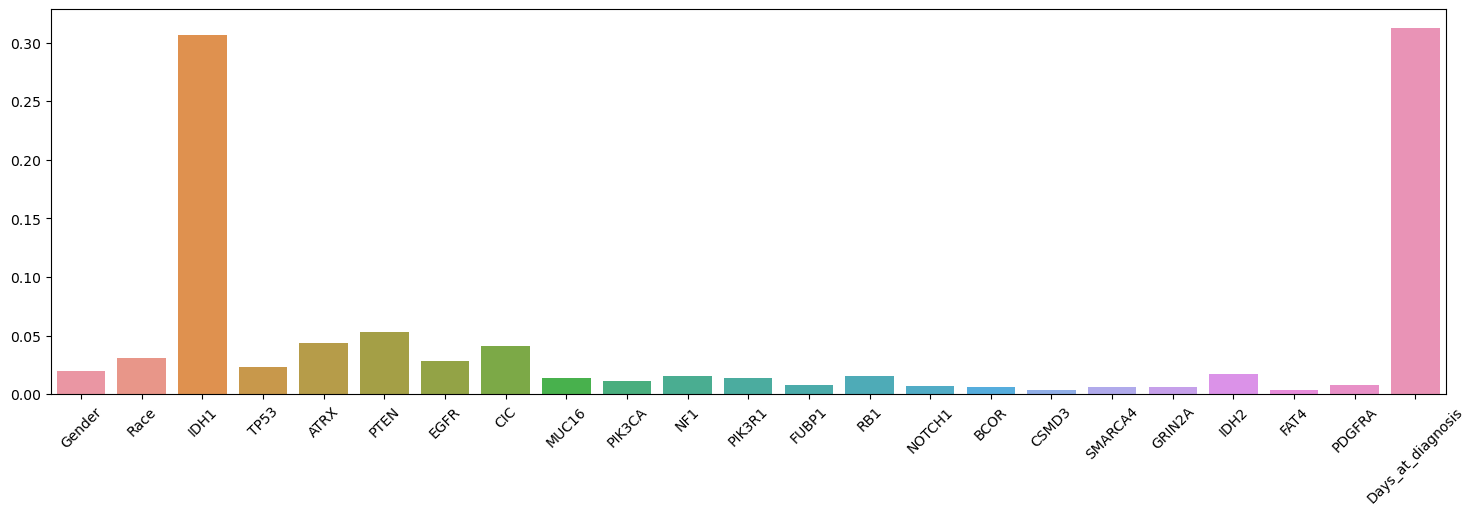

In [51]:
plt.figure(figsize=(18, 5))
sb.barplot(x=X_train.columns, y=rf.feature_importances_)
plt.xticks(rotation=45);

In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
parameters = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

In [54]:
grid = GridSearchCV(rf, parameters)
grid = grid.fit(X_train, y_train)

In [55]:
rf = grid.best_estimator_

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=8,
                       min_samples_split=5, n_estimators=6)

In [57]:
accuracy_score(rf.predict(X_test), y_test)

0.7848837209302325

In [58]:
print(classification_report(rf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        99
           1       0.74      0.77      0.75        73

    accuracy                           0.78       172
   macro avg       0.78      0.78      0.78       172
weighted avg       0.79      0.78      0.79       172



In [59]:
joblib.dump(rf, "model_rf.pkl") 

['model_rf.pkl']

#### lightgbm

In [60]:
train_dataset = lgb.Dataset(X_train, y_train, feature_name=X_scaled.columns.tolist())
test_dataset = lgb.Dataset(X_test, y_test, feature_name=X_scaled.columns.tolist())

In [61]:
booster = lgb.LGBMClassifier(objective="binary", )
booster = lgb.train({"objective": "binary", "learning_rate": 0.01, "max_depth":12, "n_estimators":200},
                    train_set=train_dataset, 
                    valid_sets=(test_dataset,),
                    num_boost_round=10)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 284, number of negative: 402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 686, number of used features: 20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413994 -> initscore=-0.347478
[LightGBM] [Info] Start training from score -0.347478
[LightGBM] [Warning] No further splits with positive gai

C:\Users\Dasha\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [62]:
test_preds = booster.predict(X_test)
train_preds = booster.predict(X_train)

test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
train_preds = [1 if pred > 0.5 else 0 for pred in train_preds]

print("Test Accuracy: %.2f"%accuracy_score(y_test, test_preds))
print("Train Accuracy: %.2f"%accuracy_score(y_train, train_preds))

Test Accuracy: 0.85
Train Accuracy: 0.89


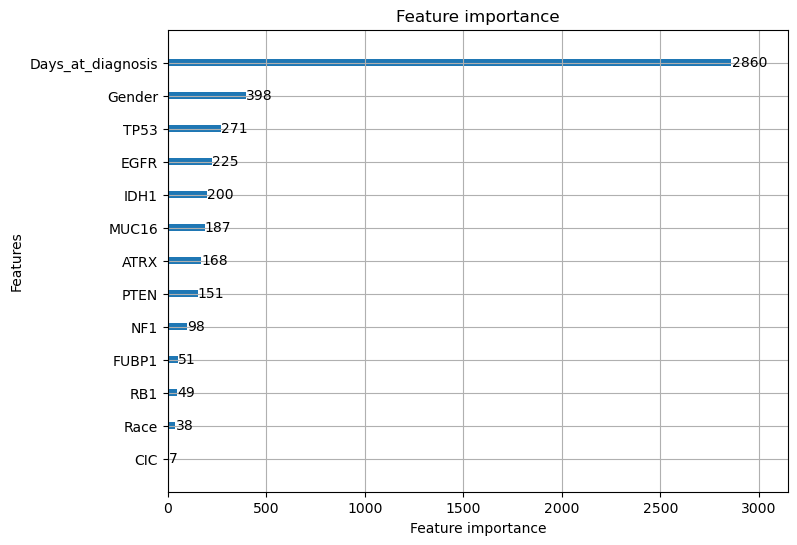

In [63]:
lgb.plot_importance(booster, figsize=(8,6));

In [64]:
booster.save_model("lgb.model")